In [102]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats
import scipy.special

import pickle as pkl

from sim_data import parse_sim_data

In [232]:
n_datasets = 5
n_pools = 20
n_markers = 3
H = 2**n_markers # number of haplotypes
pool_sizes = np.arange(10, 31, 5)

In [290]:
from matplotlib import rc, rcParams
rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex = True)
rc('font', size=16)

# colors for plotting
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

In [233]:
def get_pmean(idata):
    return idata.posterior.p.values.mean(axis=(0,1))

def get_pess(idata):
    return az.ess(idata, var_names=['p'])['p'].values

def get_pmode(idata):
    lp = idata.sample_stats.lp
    mode_idx = np.unravel_index(lp.argmax(), lp.shape)
    return idata.posterior.p.values[mode_idx]
    
def get_pmode_cgibbs(idata, lm_list, max_psize, alphas):
    logfacts = scipy.special.loggamma(np.arange(1, max_psize+2))
    if alphas.min() < 1:
        raise RuntimeError("Posterior mode may not exist for alpha < 1")
    
    basis_is = [i for i, lm in enumerate(lm_list) if lm.idx_var]    
    post_alp = alphas.copy()
    for lm in lm_list:
        post_alp[lm.idx_fix] += lm.z_fix
        
    chains, draws, H = idata.posterior.p.shape
    alp_mat = np.tile(post_alp, (chains, draws, 1))
    lp = np.zeros((chains, draws))
    for i in basis_is:
        alp_mat[:,:,lm_list[i].idx_var] += idata.posterior[f'z{i}'].values
        lp -= logfacts[idata.posterior[f'z{i}'].values].sum(axis=-1)
    pmodes = (alp_mat-1)/(alp_mat.sum(axis=-1)-H)[:,:,None]
    lp += np.sum((alp_mat-1) * np.log(pmodes, out=np.zeros(pmodes.shape), where=pmodes>0), axis=-1)
    return pmodes[np.unravel_index(lp.argmax(), lp.shape)]

def get_tot_time(sample_stats):
    longest = sample_stats.time_incl_tune.values.max()
    return (sample_stats.attrs['preprocess_time']
            + sample_stats.attrs['mcmc_walltime'] - longest
            + sample_stats.time_incl_tune.values.sum()) 

def est_time(sample_stats, ess, trg_ess):
    longest = sample_stats.time_incl_tune.values.max()
    return (sample_stats.attrs['preprocess_time']
            + sample_stats.attrs['mcmc_walltime'] - longest
            + sample_stats.time_incl_tune.values.sum()*trg_ess/ess) 

def tvd(p1, p2):
    return 0.5 * np.abs(p1-p2).sum()

In [236]:
# read in multinomial probabilities used for simulation
ptrue_by_psize = {}
for pool_size in pool_sizes:
    ptrue_arr = []
    for ds_idx in range(1, n_datasets+1):
        fn_prefix = f'../../data/sim-study/psize{pool_size}_m{n_markers}_id{ds_idx}'
        with open(fn_prefix+'.prob') as fp:
            ptrue_arr.append([float(x) for x in fp.readline().split()])
    ptrue_by_psize[pool_size] = np.array(ptrue_arr)

In [267]:
methods = ['exact', 'mn_approx', 'cgibbs_adapt']

In [268]:
# get stats from MCMC results

stats_by_psize = {}

for pool_size in pool_sizes:
    stats_dicts = []
    for ds_idx in range(1, n_datasets+1):
        stats_dict = {}
        fn_prefix = f'../../data/sim-study/psize{pool_size}_m{n_markers}_id{ds_idx}'
        for method in methods:
            #print(pool_size, ds_idx, method)
            idata = az.from_netcdf(f'{fn_prefix}_{method}.netcdf')
            if 'cgibbs' in method:
                with open(fn_prefix+'.pkl', 'rb') as fp:
                    lm_list = pkl.load(fp)
                pmode = get_pmode_cgibbs(idata, lm_list, pool_size, np.ones(H))
            else:
                pmode = get_pmode(idata)
            stats_dict[method] = {'pmean': get_pmean(idata), # posterior mean
                                  'pmode': pmode, # posterior mode
                                  'pess': get_pess(idata), # ESS of p
                                  'sample_stats': idata.sample_stats # timings
                                 }
        stats_dicts.append(stats_dict)
    stats_by_psize[pool_size] = stats_dicts

In [269]:
print('Total variation distance of posterior means to true value\n')
print(f'Pool size{" "*7}', end='')
for psize in pool_sizes:
    print(f'|{psize:^8}', end='')
print()

print('|'.join(['-'*rep for rep in [16]+[8]*len(pool_sizes)]))
for ds_idx in range(5):
    print(f'Set {ds_idx+1:<12}|', end='')
    print('|'.join([' '*8]*len(pool_sizes)))
    for method in methods:
        print(f'{method:>15} ', end='')
        for psize in pool_sizes:
            ptrue = ptrue_by_psize[psize][ds_idx]
            pmean = stats_by_psize[psize][ds_idx][method]['pmean']
            print(f'| {tvd(pmean, ptrue):.4f} ', end='')
        print()

Total variation distance of posterior means to true value

Pool size       |   10   |   15   |   20   |   25   |   30   
----------------|--------|--------|--------|--------|--------
Set 1           |        |        |        |        |        
          exact | 0.0337 | 0.0545 | 0.0390 | 0.0370 | 0.0619 
      mn_approx | 0.1067 | 0.1479 | 0.1473 | 0.1474 | 0.1814 
   cgibbs_adapt | 0.0344 | 0.0535 | 0.0380 | 0.0330 | 0.0601 
Set 2           |        |        |        |        |        
          exact | 0.1881 | 0.1637 | 0.1584 | 0.1465 | 0.1566 
      mn_approx | 0.1898 | 0.1666 | 0.1795 | 0.1544 | 0.1675 
   cgibbs_adapt | 0.1900 | 0.1623 | 0.1654 | 0.1484 | 0.1568 
Set 3           |        |        |        |        |        
          exact | 0.0849 | 0.1153 | 0.1094 | 0.0689 | 0.1008 
      mn_approx | 0.1041 | 0.0932 | 0.0960 | 0.0822 | 0.1150 
   cgibbs_adapt | 0.0862 | 0.1209 | 0.1096 | 0.0689 | 0.1018 
Set 4           |        |        |        |        |        
          e

In [270]:
print('Total variation distance of posterior modes to true value\n')
print(f'Pool size{" "*7}', end='')
for psize in pool_sizes:
    print(f'|{psize:^8}', end='')
print()

print('|'.join(['-'*rep for rep in [16]+[8]*len(pool_sizes)]))
for ds_idx in range(5):
    print(f'Set {ds_idx+1:<12}|', end='')
    print('|'.join([' '*8]*len(pool_sizes)))
    for method in methods:
        print(f'{method:>15} ', end='')
        for psize in pool_sizes:
            ptrue = ptrue_by_psize[psize][ds_idx]
            pmode = stats_by_psize[psize][ds_idx][method]['pmode']
            print(f'| {tvd(pmode, ptrue):.4f} ', end='')
        print()

Total variation distance of posterior modes to true value

Pool size       |   10   |   15   |   20   |   25   |   30   
----------------|--------|--------|--------|--------|--------
Set 1           |        |        |        |        |        
          exact | 0.0632 | 0.0598 | 0.0811 | 0.0659 | 0.0524 
      mn_approx | 0.1173 | 0.0482 | 0.0291 | 0.0534 | 0.0924 
   cgibbs_adapt | 0.0823 | 0.0790 | 0.0773 | 0.0903 | 0.0923 
Set 2           |        |        |        |        |        
          exact | 0.2378 | 0.1826 | 0.1052 | 0.1864 | 0.1984 
      mn_approx | 0.1375 | 0.1732 | 0.1598 | 0.1290 | 0.1924 
   cgibbs_adapt | 0.0830 | 0.1146 | 0.0819 | 0.1321 | 0.1396 
Set 3           |        |        |        |        |        
          exact | 0.2162 | 0.1270 | 0.0728 | 0.0636 | 0.0629 
      mn_approx | 0.0717 | 0.0897 | 0.0610 | 0.0283 | 0.0972 
   cgibbs_adapt | 0.3223 | 0.2168 | 0.3035 | 0.2815 | 0.1861 
Set 4           |        |        |        |        |        
          e

In [271]:
print('Entropy\n')
for idx in range(n_datasets):
    ptrue = ptrue_by_psize[pool_sizes[0]][idx]
    print(f'Set {idx+1}: {scipy.stats.entropy(ptrue):6.4f}')

Entropy

Set 1: 1.2758
Set 2: 1.4497
Set 3: 1.5990
Set 4: 1.4674
Set 5: 1.5284


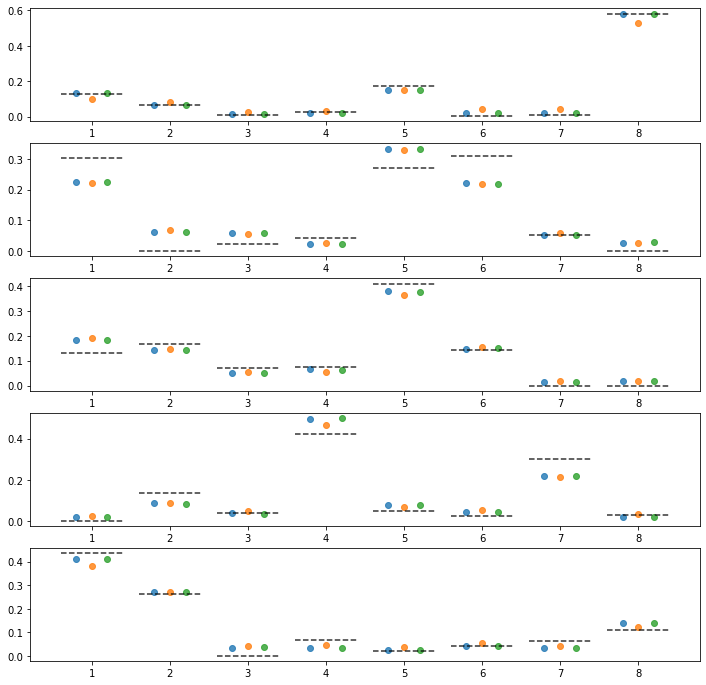

In [272]:
psize = 10
fig, axes = plt.subplots(nrows=n_datasets, figsize=(12, 12))
for idx in range(n_datasets):
    ax = axes[idx]
    for h in range(H):
        ax.plot([h+0.6, h+1.4], [ptrue_by_psize[psize][idx][h]]*2, '--', color='k', alpha=0.8);
        
    for i, method in enumerate(methods):
        ax.scatter(np.arange(1,1+H)-0.2+0.2*i, stats_by_psize[psize][idx][method]['pmean'], alpha=0.8);

In [273]:
print('Minimum effective sample size\n')
print(f'Pool size{" "*7}', end='')
for psize in pool_sizes:
    print(f'|{psize:^8}', end='')
print()

print('|'.join(['-'*rep for rep in [16]+[8]*len(pool_sizes)]))
for ds_idx in range(5):
    print(f'Set {ds_idx+1:<12}|', end='')
    print('|'.join([' '*8]*len(pool_sizes)))
    for method in methods:
        print(f'{method:>15} ', end='')
        for psize in pool_sizes:
            pess = stats_by_psize[psize][ds_idx][method]['pess']
            print(f'| {pess.min():6.0f} ', end='')
        print()

Minimum effective sample size

Pool size       |   10   |   15   |   20   |   25   |   30   
----------------|--------|--------|--------|--------|--------
Set 1           |        |        |        |        |        
          exact |   2541 |   1604 |   1278 |   1128 |    696 
      mn_approx |   1481 |   1134 |    827 |    745 |    538 
   cgibbs_adapt |   2864 |   1560 |    662 |    566 |    399 
Set 2           |        |        |        |        |        
          exact |   2022 |   1386 |   1169 |    908 |    762 
      mn_approx |   1949 |   1527 |   1219 |    948 |    873 
   cgibbs_adapt |   2820 |   1721 |    859 |    792 |    551 
Set 3           |        |        |        |        |        
          exact |    948 |    877 |   1032 |    653 |    638 
      mn_approx |   1135 |    671 |   1188 |    822 |    899 
   cgibbs_adapt |   1078 |   1129 |    910 |    453 |    364 
Set 4           |        |        |        |        |        
          exact |   2556 |   1814 |   1

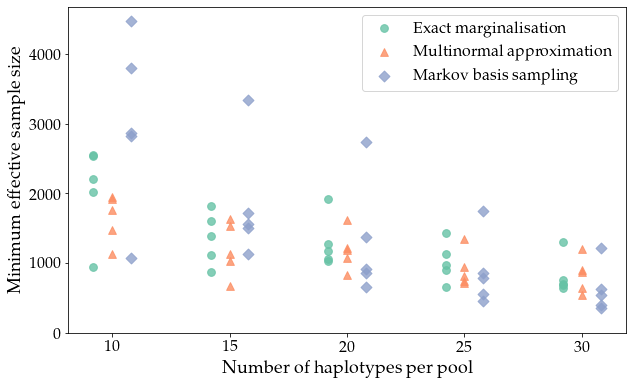

In [305]:
labels = ['Exact marginalisation',
          'Multinormal approximation',
          'Markov basis sampling']

plt.figure(figsize=(10,6))
for i, method in enumerate(methods):
    plt.scatter(np.repeat(pool_sizes+0.8*(i-1), n_datasets),
                [stat_dict[method]['pess'].min() for psize in pool_sizes for stat_dict in stats_by_psize[psize]],
                color=colors[i], alpha=0.8, s=60, marker='o^D'[i], label=labels[i]);
plt.ylim((0, plt.ylim()[1]))
plt.xlabel('Number of haplotypes per pool', fontsize=18);
plt.ylabel('Minimum effective sample size', fontsize=18);
plt.legend();

In [286]:
np.repeat(pool_sizes+0.8*(i-1), 2)

array([10.8, 10.8, 15.8, 15.8, 20.8, 20.8, 25.8, 25.8, 30.8, 30.8])

In [274]:
print('Total runtime\n')
print(f'Pool size{" "*7}', end='')
for psize in pool_sizes:
    print(f'|{psize:^8}', end='')
print()

print('|'.join(['-'*rep for rep in [16]+[8]*len(pool_sizes)]))
for ds_idx in range(5):
    print(f'Set {ds_idx+1:<12}|', end='')
    print('|'.join([' '*8]*len(pool_sizes)))
    for method in methods:
        print(f'{method:>15} ', end='')
        for psize in pool_sizes:
            tot_time = get_tot_time(stats_by_psize[psize][ds_idx][method]['sample_stats'])
            print(f'| {tot_time:6.1f} ', end='')
        print()

Total runtime

Pool size       |   10   |   15   |   20   |   25   |   30   
----------------|--------|--------|--------|--------|--------
Set 1           |        |        |        |        |        
          exact |   25.1 |   32.0 |   89.7 |  367.6 | 1989.4 
      mn_approx |   70.1 |   71.2 |   68.6 |   70.6 |   71.7 
   cgibbs_adapt |  120.4 |  106.5 |  110.7 |  100.2 |   97.9 
Set 2           |        |        |        |        |        
          exact |   22.7 |   24.8 |   31.7 |   33.9 |   60.6 
      mn_approx |   80.1 |   76.5 |   80.3 |   77.2 |   81.4 
   cgibbs_adapt |  109.3 |  105.7 |  101.1 |  105.1 |   99.8 
Set 3           |        |        |        |        |        
          exact |   21.0 |   26.6 |   36.6 |   51.5 |   89.3 
      mn_approx |   71.4 |   73.5 |   75.0 |   74.0 |   77.2 
   cgibbs_adapt |  116.5 |  103.2 |   97.7 |   97.6 |   99.5 
Set 4           |        |        |        |        |        
          exact |   26.1 |   28.2 |   57.8 |  249.1 | 1

In [275]:
print('Estimated total runtime for ESS of 1000\n')
print(f'Pool size{" "*7}', end='')
for psize in pool_sizes:
    print(f'|{psize:^8}', end='')
print()

print('|'.join(['-'*rep for rep in [16]+[8]*len(pool_sizes)]))
for ds_idx in range(5):
    print(f'Set {ds_idx+1:<12}|', end='')
    print('|'.join([' '*8]*len(pool_sizes)))
    for method in methods:
        print(f'{method:>15} ', end='')
        for psize in pool_sizes:
            tot_time = est_time(stats_by_psize[psize][ds_idx][method]['sample_stats'],
                                stats_by_psize[psize][ds_idx][method]['pess'].min(),
                                1000)
            print(f'| {tot_time:6.1f} ', end='')
        print()

Estimated total runtime for ESS of 1000

Pool size       |   10   |   15   |   20   |   25   |   30   
----------------|--------|--------|--------|--------|--------
Set 1           |        |        |        |        |        
          exact |   12.3 |   22.5 |   81.1 |  360.5 | 2030.0 
      mn_approx |   49.2 |   63.6 |   82.4 |   93.4 |  130.0 
   cgibbs_adapt |   43.3 |   68.7 |  166.8 |  176.4 |  244.1 
Set 2           |        |        |        |        |        
          exact |   12.4 |   18.4 |   27.4 |   37.2 |   75.2 
      mn_approx |   43.2 |   51.7 |   66.7 |   81.2 |   92.5 
   cgibbs_adapt |   39.9 |   62.0 |  117.5 |  132.5 |  180.3 
Set 3           |        |        |        |        |        
          exact |   22.1 |   30.1 |   35.5 |   77.1 |  128.3 
      mn_approx |   63.3 |  107.4 |   63.8 |   89.0 |   85.3 
   cgibbs_adapt |  108.1 |   91.5 |  107.2 |  214.3 |  272.0 
Set 4           |        |        |        |        |        
          exact |   11.6 |   